In [1]:
import csv
import pandas as pd
import sklearn.model_selection as skm
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import fasttext.util
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import stanza
from sklearn.ensemble import RandomForestClassifier

ModuleNotFoundError: No module named 'fasttext'

In [ ]:
data = pd.read_csv('yelp_labelled.txt', header=None, sep='\t')
# data.head(5)

In [ ]:
X_text = data[0]
y = data[1]

X_text_train, X_text_temp, y_train, y_temp = skm.train_test_split(X_text, y, test_size=0.3, stratify=y, random_state=0)
X_text_dev, X_text_test, y_dev, y_test = skm.train_test_split(X_text_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=0)

In [2]:
# !pip install fasttext stanza
# !pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 32.6 MB/s eta 0:00:00
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296183 sha256=45a208e6eedef7ab03096c9ad6ec041e173fd05462c201ddefa21f23528cc088
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.7/268.7 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.2.1
    Uninstalling

In [ ]:
fasttext.util.download_model('en', if_exists='ignore')
model = fasttext.load_model('cc.en.300.bin')

In [ ]:
X_train = [model.get_sentence_vector(text) for text in X_text_train]
X_dev = [model.get_sentence_vector(text) for text in X_text_dev]
X_test = [model.get_sentence_vector(text) for text in X_text_test]

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_dev_accuracy = accuracy_score(y_dev, svm_clf.predict(X_dev))

logr_clf = LogisticRegression()
logr_clf.fit(X_train, y_train)
logr_dev_accuracy = accuracy_score(y_dev, logr_clf.predict(X_dev))

best_clf = logr_clf if logr_dev_accuracy > svm_dev_accuracy else svm_clf
test_accuracy = accuracy_score(y_test, best_clf.predict(X_test))
print("Accuracy for best model: %.3f" % test_accuracy)

Accuracy for best model: 0.800


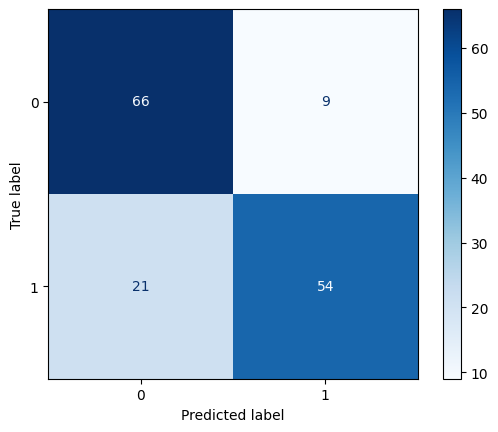

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        best_clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    )

In [ ]:
st_model = SentenceTransformer('all-MiniLM-L6-v2')

batch_size = 64
X_train_st = st_model.encode(X_text_train.tolist(), batch_size=batch_size)
X_dev_st = st_model.encode(X_text_dev.tolist(), batch_size=batch_size)
X_test_st = st_model.encode(X_text_test.tolist(), batch_size=batch_size)

logr_st_clf = LogisticRegression()
logr_st_clf.fit(X_train_st, y_train)
logr_st_dev_accuracy = accuracy_score(y_dev, logr_st_clf.predict(X_dev_st))

test_st_accuracy = accuracy_score(y_test, logr_st_clf.predict(X_test_st))
print("Transformers + LogReg Accuracy: %.3f" % test_st_accuracy)

Test set accuracy (Transformers + LogReg): 0.907


In [ ]:
rf_clf_ft = RandomForestClassifier()
rf_clf_ft.fit(X_train, y_train)
rf_ft_dev_accuracy = accuracy_score(y_dev, rf_clf_ft.predict(X_dev))

rf_clf_st = RandomForestClassifier()
rf_clf_st.fit(X_train_st, y_train)
rf_st_dev_accuracy = accuracy_score(y_dev, rf_clf_st.predict(X_dev_st))

print(f"RF + FT Accuracy: {rf_ft_dev_accuracy}")
print(f"RF + Transformers Accuracy: {rf_st_dev_accuracy}")

Random Forest + FastText Dev Accuracy: 0.74
Random Forest + SentenceTransformers Dev Accuracy: 0.8733333333333333


In [ ]:
# from startet notebook
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', tokenize_no_ssplit=True)
collection = '\n\n'.join(X_text_test)
doc = nlp(collection)

stanza_predictions = []
for i, sentence in enumerate(doc.sentences):
    if sentence.sentiment == 0 or sentence.sentiment == 1:
        stanza_predictions.append(0)
    if sentence.sentiment == 2:
        stanza_predictions.append(1)

stanza_accuracy = accuracy_score(y_test, stanza_predictions)
print("Stanza Sentiment Accuracy: %.3f" % stanza_accuracy)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
/usr/local/lib/python3.10/dist-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode un

Stanza Sentiment Accuracy: 0.907


In [ ]:
print(f"FastText + SVM Test Accuracy: %.3f" % svm_dev_accuracy)
print(f"FastText + Logistic Regression Test Accuracy: %.3f" % logr_dev_accuracy)
print(f"SentenceTransformers + Logistic Regression Test Accuracy: %.3f" % test_st_accuracy)
print(f"Stanza Sentiment Test Accuracy: %.3f" % stanza_accuracy)

FastText + SVM Test Accuracy: 0.820
FastText + Logistic Regression Test Accuracy: 0.787
SentenceTransformers + Logistic Regression Test Accuracy: 0.907
Stanza Sentiment Test Accuracy: 0.907


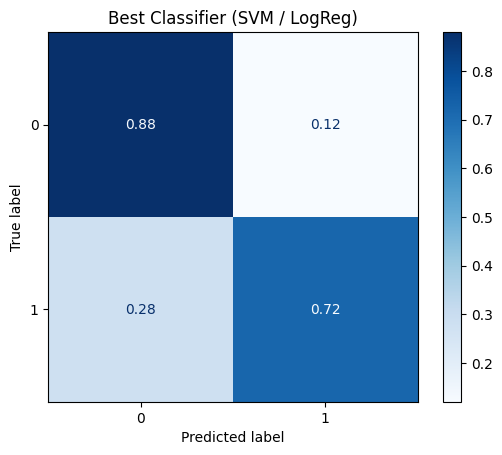

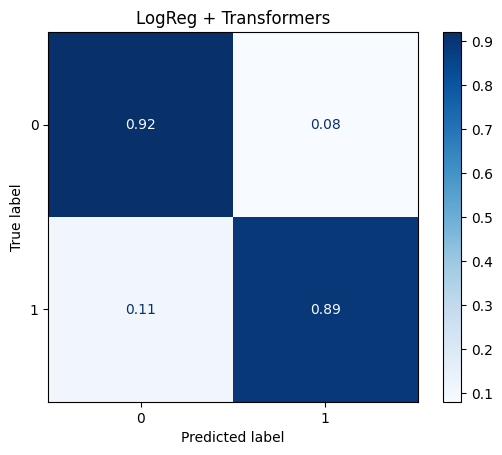

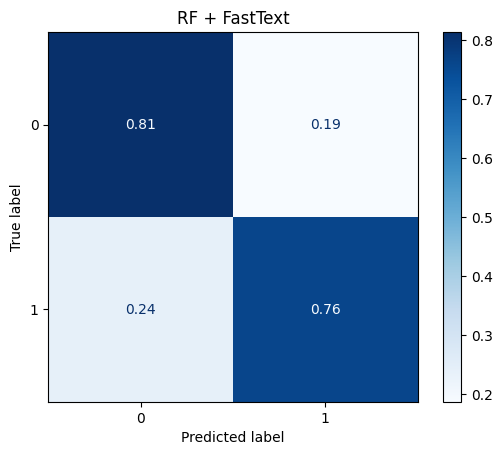

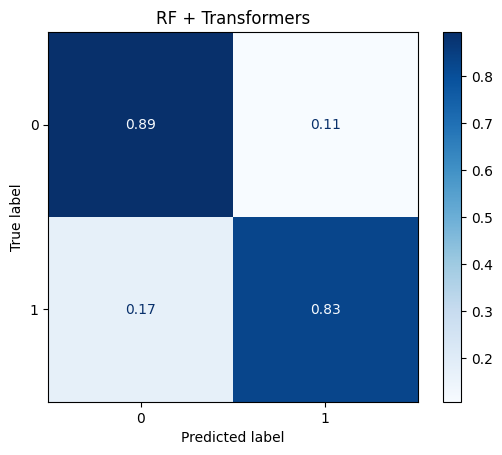

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_clf,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize='true'
)
disp.ax_.set_title("Best Classifier (SVM / LogReg)")
plt.show()

disp = ConfusionMatrixDisplay.from_estimator(
    logr_st_clf,
    X_test_st,
    y_test,
    cmap=plt.cm.Blues,
    normalize='true'
)
disp.ax_.set_title("LogReg + Transformers")
plt.show()

disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf_ft,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize='true'
)
disp.ax_.set_title("RF + FastText")
plt.show()

disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf_st,
    X_test_st,
    y_test,
    cmap=plt.cm.Blues,
    normalize='true'
)
disp.ax_.set_title("RF + Transformers")
plt.show()